In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, Dropout,
    MultiHeadAttention, GlobalAveragePooling1D,
    Masking
)
from tensorflow.keras.utils import to_categorical
from keras.utils import custom_object_scope
from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Preprocessed Time Series Final.csv')

In [4]:
df.head()

,event_type,product_id,category_id,price,user_id,user_session,category_code_0,category_code_1,category_code_2,category_code_3,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,1,1002532,2.053010e+18,0.937399,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,26204062,2.053010e+18,-0.188667,515547943,4737b7aa-83f7-4899-86e0-2d53b2ddbffc,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,4804055,2.053010e+18,-0.342339,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,1307240,2.053010e+18,0.211381,520575653,9acd3cb7-79b7-4293-bb81-bec02a1c9cd3,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,1002524,2.053010e+18,0.578390,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
features = ['price'] + [f'category_code_{i}' for i in range(5)] + [f'brand_{i}' for i in range(12)]

In [6]:
 #Step 2: Prepare X and y
X = df[features].values  # shape (num_samples, num_features)
y = df['event_type'].values  # labels (strings)


In [7]:
# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
y_onehot = to_categorical(y_encoded, num_classes=num_classes)

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)

In [9]:
# Reshape input for Transformer: (samples, timesteps, features)
# Here seq_length = 1 for simplicity, but ideally >1 for Transformer
seq_length = 1
num_features = len(features)
X_train = X_train.reshape((X_train.shape[0], seq_length, num_features))
X_test = X_test.reshape((X_test.shape[0], seq_length, num_features))

In [10]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # Residual connection

    # Feed-forward network
    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res  # Residual connection

In [11]:
# Build Transformer model
inputs = Input(shape=(seq_length, num_features))
x = Masking(mask_value=0.)(inputs)

x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

In [12]:
model = Model(inputs, outputs)

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19995/20000 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4426 - loss: 1.0438

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 127s 6ms/step - accuracy: 0.4426 - loss: 1.0438 - val_accuracy: 0.4641 - val_loss: 1.0213
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 121s 6ms/step - accuracy: 0.4618 - loss: 1.0210 - val_accuracy: 0.4709 - val_loss: 1.0112
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 140s 6ms/step - accuracy: 0.4662 - loss: 1.0137 - val_accuracy: 0.4717 - val_loss: 1.0070
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 154s 7ms/step - accuracy: 0.4693 - loss: 1.0095 - val_accuracy: 0.4732 - val_loss: 1.0052
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 130s 7ms/step - accuracy: 0.4717 - loss: 1.0067 - val_accuracy: 0.4725 - val_loss: 1.0033
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 150s 7ms/step - accuracy: 0.4718 - loss: 1.0047 - val_accuracy: 0.4744 - val_loss: 1.0032
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - accuracy: 0.4714 - loss: 1.0044 - val_accuracy: 0.4762 - val_loss: 1.0005
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 136s 7ms/step - accuracy: 0.4

In [15]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.4757 - loss: 0.9970
Test Accuracy: 0.4755


   1/6250 ━━━━━━━━━━━━━━━━━━━━ 25:16 243ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step


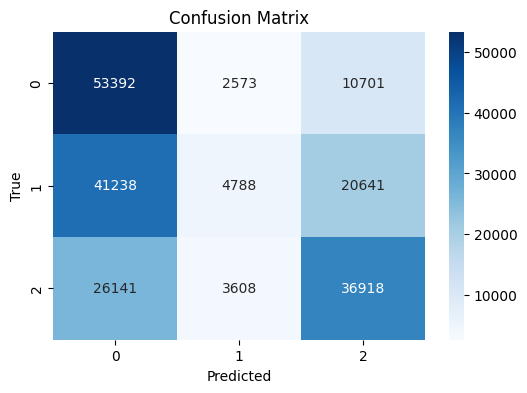

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Get predicted classes for test set
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
from tensorflow.keras.models import load_model

# Save the model
model.save('transformer_model.h5')

